In [1]:
import math 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt 
import yfinance as yf
import numpy as np 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
plt.style.use('fivethirtyeight')

2023-05-25 23:29:40.962875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set the ticker symbol for Apple
ticker = "AAPL"

# Set the start and end dates for the historical data
start_date = "2018-01-01"
end_date = "2023-04-01"

# Load the historical stock price data from Yahoo Finance
df = yf.download(ticker, start=start_date, end=end_date)

# Print the first few rows of the data
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.831581,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.824482,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.014103,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.481071,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.326996,82271200


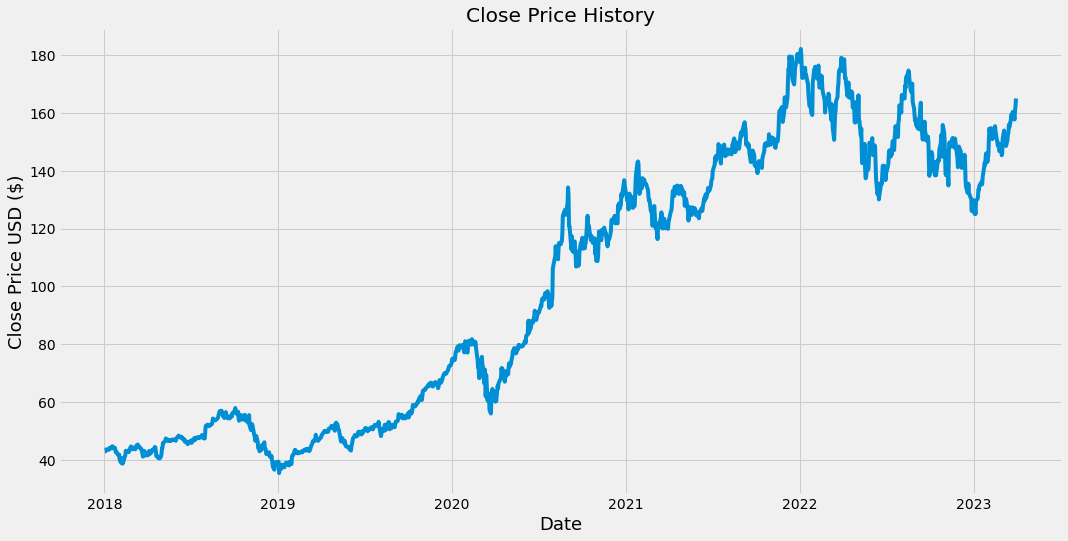

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [4]:
#Creat a newdataframe with onlhy 'Close Column'
data=df.filter(['Close'])
#Convert the dataframe to numpy array
dataset = data.values
#get the length of training model 
training_data_len = math.ceil(len(dataset)* .8)
training_data_len

1057

In [5]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data= scaler.fit_transform(dataset)

scaled_data

array([[0.05132712],
       [0.05127591],
       [0.05264146],
       ...,
       [0.85498   ],
       [0.865836  ],
       [0.88317828]])

In [6]:
#Create the training data set 
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train datasets 
x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [7]:
#Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)


In [8]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(997, 60, 1)

In [9]:
#Build the LSTM model 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

2023-05-25 23:29:47.948383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 23:29:47.950501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 23:29:47.952613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [10]:
#Compile the model 
model.compile(optimizer='adam', loss="mean_squared_error")


In [11]:
# Cross-validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
r2_scores = []

for train_index, test_index in tscv.split(x_train):
    X_train, X_test = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    model.fit(X_train, y_train_fold, batch_size=1, epochs=1, verbose=0)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test_fold, y_pred)
    r2_scores.append(r2)

# Print the cross-validation scores
print("Cross-Validation R-squared (R2) Scores:", r2_scores)



2023-05-25 23:29:48.576627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-25 23:29:48.577964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-25 23:29:48.579443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 15ms/step
Cross-Validation R-squared (R2) Scores: [0.7918439666082724, 0.9586763053286289, 0.9655138016040155, 0.7008486297869789, 0.9320577641511594]


In [12]:
# Cross-validation using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
r2_scores = []

for train_index, test_index in tscv.split(x_train):
    X_train, X_test = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    model.fit(X_train, y_train_fold, batch_size=1, epochs=1, verbose=0)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test_fold, y_pred)
    r2_scores.append(r2)

# Print the cross-validation scores
print("Cross-Validation R-squared (R2) Scores:", r2_scores)

3/3 [==============================] - 0s 11ms/step
Cross-Validation R-squared (R2) Scores: [0.952509135441492, 0.9478020014277865, 0.7941348302947673, 0.982460359065625, 0.8716398322939477, 0.9324444421276785, 0.6690874692587552, 0.659389586310611, -0.20930948944669447, 0.20930545727521688]


In [13]:
#Create the testing data set 
#Create a new array containing scaled values 
test_data=scaled_data[training_data_len - 60:, :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [14]:
#Convert the data to a numpy array
x_test = np.array(x_test)


In [15]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [16]:
#Get the models predcited price values 
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

9/9 [==============================] - 0s 10ms/step


In [17]:


# Calculate additional evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Print the metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)


Mean Absolute Error (MAE): 5.8931632186427265
Mean Squared Error (MSE): 43.949703067165856
Root Mean Squared Error (RMSE): 6.629457222666563
R-squared (R2) Score: 0.6832938364640417


/var/folders/42/k3sk25md2h77zn6_gd18bgqh0000gn/T/ipykernel_7442/790568035.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


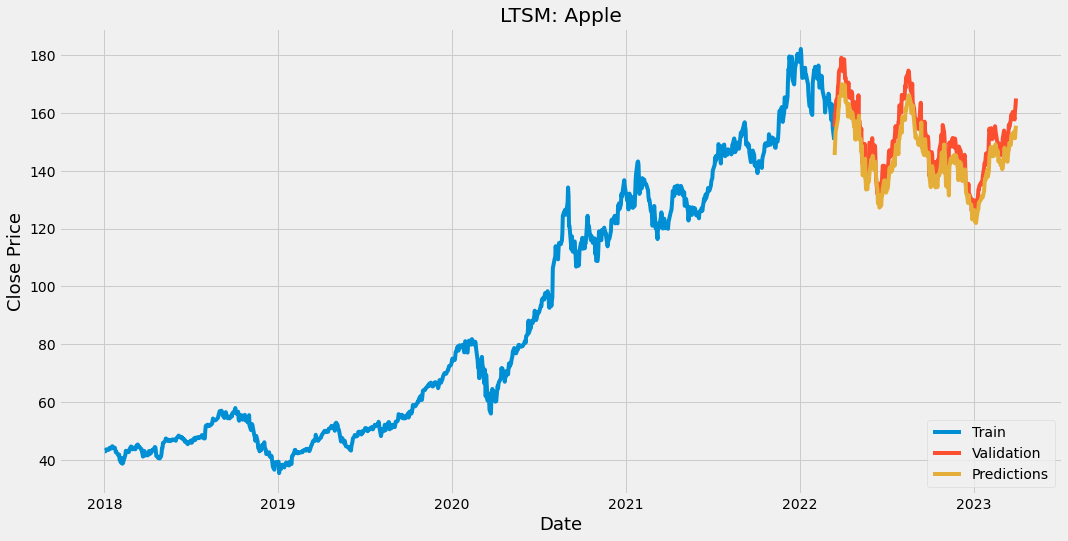

In [18]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('LTSM: Apple')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()
